In [1]:
from iminuit import Minuit
import matplotlib.pyplot as plt
from matplotlib import transforms
from matplotlib import rc
from IPython.display import Image
import numpy as np
from astropy.io import fits as pyfits
from astropy.io import fits
from scipy.ndimage import gaussian_filter
import scipy
from scipy.optimize import minimize, rosen, rosen_der
from scipy.special import factorial
import scipy.integrate as integrate
from scipy.integrate import quad
from itertools import starmap
from scipy import optimize
import corner
import time
from mpl_toolkits import mplot3d
import healpy as hp
from scipy import nan
import dark_matter_jfactors as dmj
import math
import random
import importlib
from pymultinest.solve import solve
import pymultinest
import warnings
warnings.filterwarnings("ignore")
import scipy as sp
import scipy.interpolate
import json
from os import walk
import re

In [2]:
filelist = ['Bremss_00320087_E_50-814008_MeV_healpix_128.fits', 'Bremss_SL_Z6_R20_T100000_C5_E_50-814008_MeV_healpix_128.fits', 'pi0_Model_A_E_50-814008_MeV_healpix_128.fits', 'pi0_Model_F_E_50-814008_MeV_healpix_128.fits', 'ICS_Model_A_E_50-814008_MeV_healpix_128.fits', 'ICS_Model_F_E_50-814008_MeV_healpix_128.fits']

#new_filelist = ['./results_lowerE/bremss_ionized_healpix_54_002a001k.gz', './results_lowerE/pi0_decay_healpix_54_002a001k.fits', './results_lowerE/bremss_ionized_healpix_54_002a001k.fits', './results_lowerE/ics_isotropic_healpix_54_002a001k.fits']
new_filelist = ['./results_lowerE/results_54_low_energy/pi0_decay_healpix_54_036d001f']



In [3]:
def readfile(filename):
    """
    A simple function to read the maps of a given number n and given filename.
    """
    file_to_read = fits.open(filename)
    return file_to_read

In [4]:

old_brem = readfile(filelist[2])
new_brem = readfile(new_filelist[0])

In [5]:
old_energy = []
new_energy = []

for en in new_brem[2].data:
    new_energy.append(en[0])
    
for en in old_brem[38].data:
    old_energy.append(en[0])


In [6]:
print(new_brem[1].header)

XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / 8-bit bytes                                    NAXIS   =                    2 / 2-dimensional binary table                     NAXIS1  =                  280 / width of table in bytes                        NAXIS2  =                49152 / number of rows in table                        PCOUNT  =                    0 / size of special data area                      GCOUNT  =                    1 / one data group (required keyword)              TFIELDS =                    1 / number of fields in each row                   TTYPE1  = 'Spectra '           / label for field   1                            TFORM1  = '35D     '           / data format of field: 8-byte DOUBLE            TUNIT1  = 'Intensity'          / physical unit of field                         EXTNAME = 'SKYMAP  '           / name of this binary table extension            PIXTYPE = 'HEALPIX '                    

In [7]:


print(len(new_brem[1].data))
big_array = np.empty((35, len(new_brem[1].data.T)))

print(big_array.shape)

for i in range(0, len(new_brem[1].data.T)):
    for j in range(0, 35):
        big_array[j][i] =  new_brem[1].data[i][0][j]   

49152
(35, 49152)


In [8]:
print(old_brem[0].header)

SIMPLE  =                    T / Written by IDL:  Thu Jul 10 16:33:06 2014      BITPIX  =                  -64 / Number of bits per data pixel                  NAXIS   =                    1 / Number of data axes                            NAXIS1  =               196608 /                                                EXTEND  =                    T /Extensions may be present                       DATE    = '2014-07-10T21:33:07' / Creation date                                 COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  COMMENT and Astrophysics', volume 376, page 359; bibcode 2001A&A...376..359H    PIXTYPE = 'HEALPIX '           / Pixel algorithm                                ORDERING= 'RING    '           / Ordering scheme                                NSIDE   =                  128 / Resolution parameter                           NPIX    =               196608 / # of pixels                                    FIRSTPIX=                    0 / First p

In [9]:
print(old_brem.info())

Filename: pi0_Model_A_E_50-814008_MeV_healpix_128.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (196608,)   float64   
  1                1 ImageHDU        36   (196608,)   float64   
  2                1 ImageHDU        36   (196608,)   float64   
  3                1 ImageHDU        36   (196608,)   float64   
  4                1 ImageHDU        36   (196608,)   float64   
  5                1 ImageHDU        36   (196608,)   float64   
  6                1 ImageHDU        36   (196608,)   float64   
  7                1 ImageHDU        36   (196608,)   float64   
  8                1 ImageHDU        36   (196608,)   float64   
  9                1 ImageHDU        36   (196608,)   float64   
 10                1 ImageHDU        36   (196608,)   float64   
 11                1 ImageHDU        36   (196608,)   float64   
 12                1 ImageHDU        36   (196608,)   float64   
 13                1 ImageHDU        3

In [10]:
old_sum = []
for bin_here in range(0, len(old_brem)-1):
    old_sum.append(np.nansum(old_brem[bin_here].data))

new_sum = []
for bin_here in range(0, len(big_array)):
    new_sum.append(np.nansum(big_array[bin_here]))
    


In [38]:
##Make a mask that is 1 within 10 degrees of the GC, so that we can add it and get the total flux in the region
vec = hp.ang2vec(0.0, 0.0, lonlat=True)
large_disk = hp.query_disc(64, vec, radius=np.radians(100))

mask = np.zeros(196608)
mask[large_disk] = 1

total_energy2 = np.zeros(38)

for e in range(0, len(old_energy)):
    total_energy2[e] = np.sum(old_brem[e].data[large_disk])*old_energy[e]**2

In [53]:
##Make a mask that is 1 within 10 degrees of the GC, so that we can add it and get the total flux in the region
vec = hp.ang2vec(0.0, 0.0, lonlat=True)
large_disk = hp.query_disc(64, vec, radius=np.radians(100))

mask = np.zeros(49152)
mask[large_disk] = 1

total_energy = np.zeros(35)
energies = np.zeros(35)

for e in range(0, len(new_energy)):
    print(e)
    print(1.5**e)
    print('------------------')
    energies[e] = 1 * np.sqrt(1.5) * 1.5**e
    total_energy[e] = np.sum(mask*big_array[e])


0
1.0
------------------
1
1.5
------------------
2
2.25
------------------
3
3.375
------------------
4
5.0625
------------------
5
7.59375
------------------
6
11.390625
------------------
7
17.0859375
------------------
8
25.62890625
------------------
9
38.443359375
------------------
10
57.6650390625
------------------
11
86.49755859375
------------------
12
129.746337890625
------------------
13
194.6195068359375
------------------
14
291.92926025390625
------------------
15
437.8938903808594
------------------
16
656.8408355712891
------------------
17
985.2612533569336
------------------
18
1477.8918800354004
------------------
19
2216.8378200531006
------------------
20
3325.256730079651
------------------
21
4987.885095119476
------------------
22
7481.8276426792145
------------------
23
11222.741464018822
------------------
24
16834.112196028233
------------------
25
25251.16829404235
------------------
26
37876.75244106352
------------------
27
56815.128661595285
----------

In [44]:
##Quick Comparison from other notebook
energies_normal = [1.22474487e+02, 1.83711731e+02, 2.75567596e+02, 4.13351394e+02, 6.20027091e+02, 9.30040637e+02, 1.39506096e+03, 2.09259143e+03, 3.13888715e+03, 4.70833072e+03, 7.06249609e+03, 1.05937441e+04, 1.58906162e+04, 2.38359243e+04, 3.57538864e+04, 5.36308296e+04, 8.04462445e+04, 1.20669367e+05, 1.81004050e+05, 2.71506075e+05, 4.07259113e+05, 6.10888669e+05, 9.16333003e+05] 
total_energy_normal = [10.06029436, 17.33439928, 23.92634203, 24.96160491, 22.36205766, 18.87664164, 14.77032753, 10.69636381,  7.4392548, 5.24704683, 3.77485467,  2.76275854, 2.04378224, 1.52035482,  1.13282956,  0.84010881,  0.61883223,  0.45201838, 0.33063118,  0.24206041,  0.17864012,  0.13253404,  0.09904796]


In [54]:
print(new_energy)

[1.0, 1.5, 2.25, 3.375, 5.0625, 7.593750000000002, 11.390625, 17.085937499999996, 25.62890625, 38.44335937500001, 57.66503906250003, 86.49755859374999, 129.746337890625, 194.61950683593756, 291.92926025390614, 437.8938903808593, 656.8408355712891, 985.2612533569338, 1477.891880035401, 2216.8378200531, 3325.256730079654, 4987.885095119478, 7481.827642679212, 11222.74146401883, 16834.112196028233, 25251.168294042334, 37876.752441063545, 56815.12866159528, 85222.69299239285, 127834.03948858943, 191751.05923288403, 287626.58884932636, 431439.88327398925, 647159.8249109834, 970739.7373664762]


In [47]:
for i in range(0, len(energies)-1):
    print(np.log10(energies[i])-np.log10(energies[i+1]))
print('------------------')
for i in range(0, len(new_energy)-1):
    print(np.log10(new_energy[i])-np.log10(new_energy[i+1]))

-0.17609125905568124
-0.1760912590556813
-0.17609125905568118
-0.17609125905568124
-0.17609125905568135
-0.17609125905568124
-0.17609125905568113
-0.17609125905568135
-0.17609125905568113
-0.17609125905568135
-0.17609125905568113
-0.17609125905568135
-0.17609125905568135
-0.1760912590556809
-0.17609125905568135
-0.17609125905568135
-0.17609125905568135
-0.1760912590556809
-0.17609125905568135
-0.17609125905568135
-0.17609125905568135
-0.1760912590556809
-0.17609125905568135
-0.17609125905568135
-0.17609125905568135
-0.17609125905568135
-0.17609125905568135
-0.17609125905568135
-0.17609125905568046
-0.17609125905568135
-0.17609125905568135
-0.17609125905568135
-0.17609125905568135
-0.17609125905568135
------------------
-0.17609125905568124
-0.17609125905568124
-0.17609125905568124
-0.17609125905568124
-0.17609125905568135
-0.17609125905568113
-0.17609125905568113
-0.17609125905568135
-0.17609125905568135
-0.17609125905568135
-0.1760912590556809
-0.17609125905568135
-0.17609125905568135

Text(0, 0.5, 'cm^-2 s^-1 MeV^-1 str^-1')

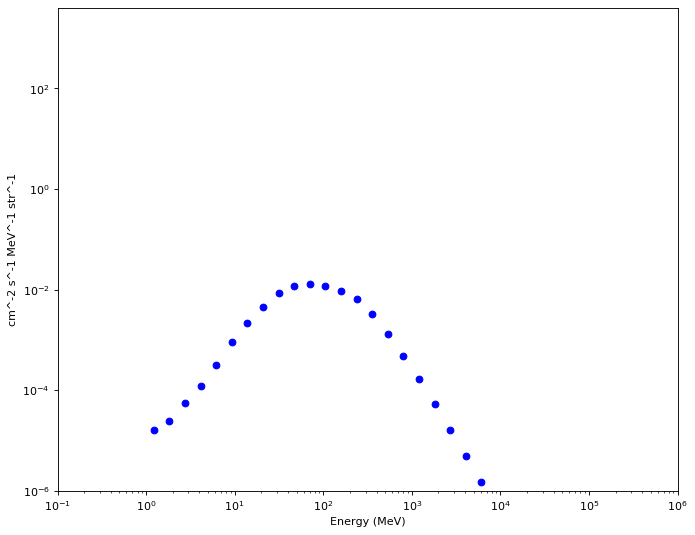

In [45]:
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(energies, total_energy, color= 'blue')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('MeV')
plt.ylim(1e-6, 4e3)
plt.xlim(1e-1, 1e6)
plt.xlabel('Energy (MeV)')
plt.ylabel('cm^-2 s^-1 MeV^-1 str^-1')

Text(0, 0.5, 'E$^2$ dN/dE (MeV cm$^{-2}$s$^{-1}$)')

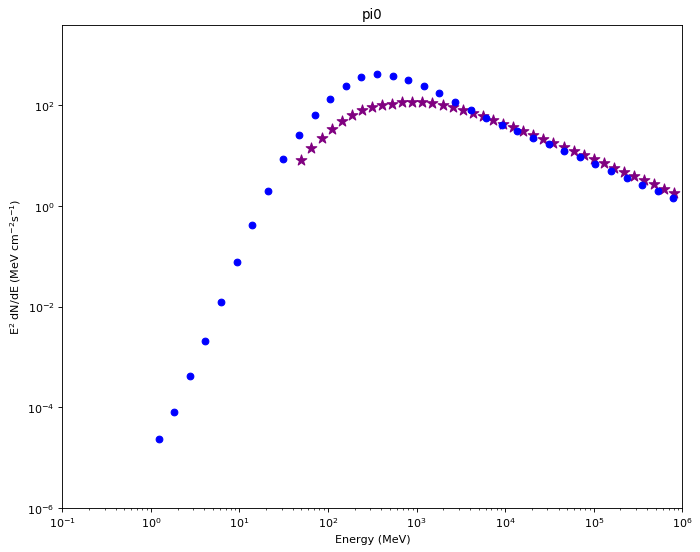

In [41]:
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(old_energy, total_energy2*4*np.pi, color = 'purple', marker = '*', s = 100)
plt.scatter(energies, total_energy, color= 'blue')
#plt.plot(energies_normal, total_energy_normal, color = 'green')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('MeV')
plt.ylim(1e-6, 4e3)
plt.xlim(1e-1, 1e6)
plt.title('pi0')
plt.xlabel('Energy (MeV)')
plt.ylabel('E$^2$ dN/dE (MeV cm$^{-2}$s$^{-1}$)')

Text(0, 0.5, 'E$^2$ dN/dE (MeV cm$^{-2}$s$^{-1}$)')

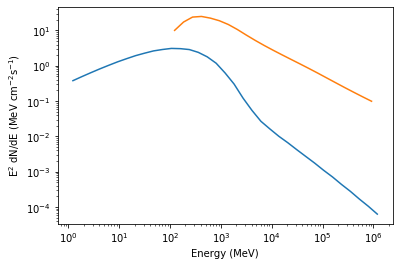

In [63]:
plt.xscale('log')
plt.yscale('log')
plt.plot(energies, total_energy)
plt.plot(energies_normal, total_energy_normal)
plt.xlabel('Energy (MeV)')
plt.ylabel('E$^2$ dN/dE (MeV cm$^{-2}$s$^{-1}$)')

In [10]:
#pi0 time
old_pi0 = readfile(filelist[2])
new_pi0 = readfile(new_filelist[1])



print(len(new_pi0[1].data))
big_arraypi0 = np.empty((40, len(new_pi0[1].data.T)))

print(big_arraypi0.shape)

for i in range(0, len(new_pi0[1].data.T)):
    for j in range(0, 40):
        big_arraypi0[j][i] =  new_pi0[1].data[i][0][j]   

196608
(40, 196608)


In [11]:
old_sumpi0 = []
for bin_here in range(0, len(old_pi0)-1):
    old_sumpi0.append(np.nansum(old_pi0[bin_here].data))

new_sumpi0 = []
for bin_here in range(0, len(big_arraypi0)):
    new_sumpi0.append(np.nansum(big_arraypi0[bin_here]))
    


(0.1, 1000000.0)

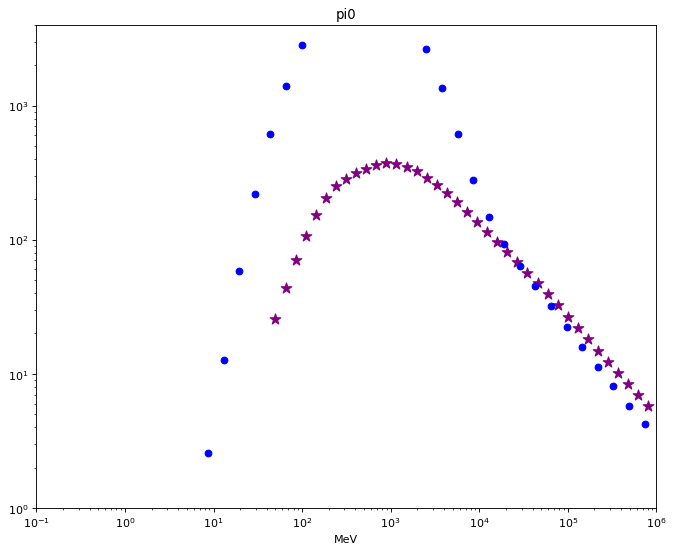

In [16]:
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(old_energy, old_sumpi0*np.array(old_energy)**2, color = 'purple', marker = '*', s = 100)
plt.scatter(new_energy, new_sumpi0*np.array(new_energy)**2, color = 'blue')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('MeV')
plt.ylim(1e0, 4e3)
plt.title('pi0')
plt.xlim(1e-1, 1e6)

In [17]:
#ics time
old_ics = readfile(filelist[4])
new_ics = readfile(new_filelist[3])



print(len(new_ics[1].data))
big_arrayics = np.empty((40, len(new_ics[1].data.T)))

print(big_arrayics.shape)

for i in range(0, len(new_ics[1].data.T)):
    for j in range(0, 40):
        big_arrayics[j][i] =  new_ics[1].data[i][0][j]   

196608
(40, 196608)


In [20]:
old_sumics = []
for bin_here in range(0, len(old_ics)-1):
    old_sumics.append(np.nansum(old_ics[bin_here].data))

new_sumics = []
for bin_here in range(0, len(big_arrayics)):
    new_sumics.append(np.nansum(big_arrayics[bin_here]))
    


(0.1, 1000000.0)

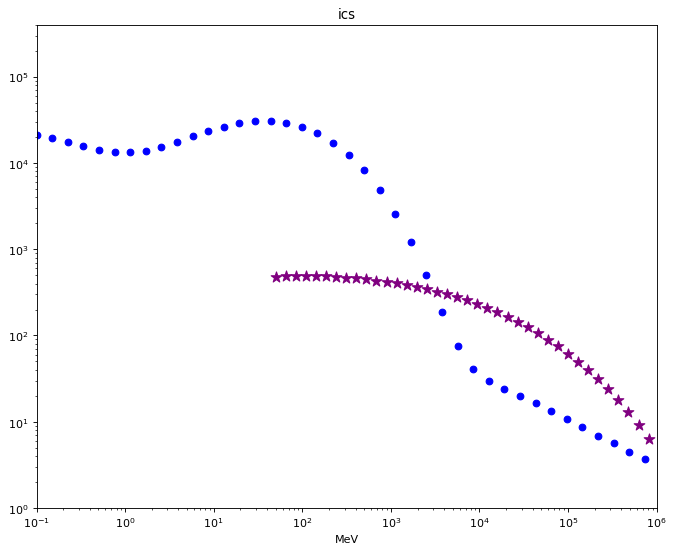

In [22]:
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(old_energy, old_sumics*np.array(old_energy)**2, color = 'purple', marker = '*', s = 100)
plt.scatter(new_energy, new_sumics*np.array(new_energy)**2, color = 'blue')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('MeV')
plt.ylim(1e0, 4e5)
plt.title('ics')
plt.xlim(1e-1, 1e6)

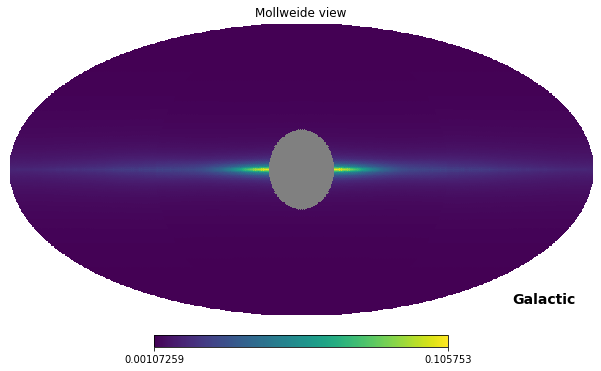

In [250]:

numpix = np.linspace(0, new_brem[1].header['LASTPIX']-1, num = new_brem[1].header['LASTPIX'])
NSIDE = int(new_brem[1].header['NSIDE'])
vec = hp.ang2vec(np.pi/2, 0)
ipix_disc = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(20), inclusive = False)
cut_bigarr = np.copy(big_array[0])
cut_bigarr[ipix_disc] = np.nan
hp.mollview(cut_bigarr, coord = 'G')

40
[[3.42375034e-03 3.86331092e-03 3.95636280e-03 ... 5.35794029e-03
  5.88969213e-03 5.86303214e-03]
 [2.17789688e-03 2.45828390e-03 2.51765190e-03 ... 3.41239509e-03
  3.75171542e-03 3.73480250e-03]
 [1.37945169e-03 1.55743610e-03 1.59513036e-03 ... 2.16359325e-03
  2.37907719e-03 2.36840763e-03]
 ...
 [1.35497784e-04 1.53133168e-04 1.56873322e-04 ... 2.13469054e-04
  2.34871502e-04 2.33854367e-04]
 [8.44869087e-05 9.55067185e-05 9.78446002e-05 ... 1.33243081e-04
  1.46623670e-04 1.45993797e-04]
 [5.25004010e-05 5.93658693e-05 6.08228933e-05 ... 8.28964531e-05
  9.12369161e-05 9.08480980e-05]]


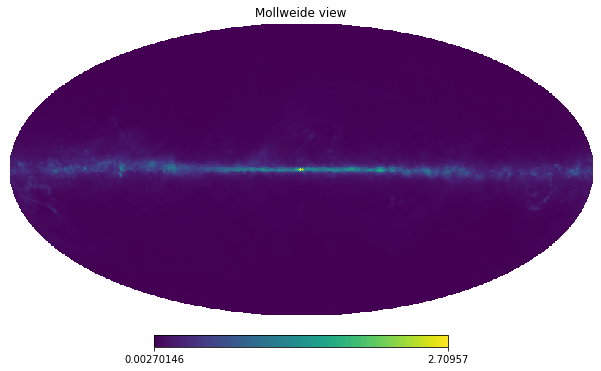

In [184]:
print(len(big_array))
print(big_array[0:10])
hp.mollview(big_array[0])

In [84]:
print(new_brem[1].header)
print(new_brem[2].data)
print((new_brem[1].data).shape)

XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / 8-bit bytes                                    NAXIS   =                    2 / 2-dimensional binary table                     NAXIS1  =                  320 / width of table in bytes                        NAXIS2  =                49152 / number of rows in table                        PCOUNT  =                    0 / size of special data area                      GCOUNT  =                    1 / one data group (required keyword)              TFIELDS =                    1 / number of fields in each row                   TTYPE1  = 'Spectra '           / label for field   1                            TFORM1  = '40D     '           / data format of field: 8-byte DOUBLE            TUNIT1  = 'Intensity'          / physical unit of field                         EXTNAME = 'SKYMAP  '           / name of this binary table extension            PIXTYPE = 'HEALPIX '                    

In [65]:
old_ics = readfile(filelist[4])
new_ics = readfile(new_filelist[2])

print(new_ics.info())


Filename: ./results_lowerE/ics_isotropic_healpix_54_002a001i.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SKYMAP        1 BinTableHDU     20   49152R x 1C   [23D]   
  2  ENERGIES      1 BinTableHDU     12   23R x 1C   [1D]   
None


In [61]:
old_pi = readfile(filelist[2])
new_pi = readfile(new_filelist[0])

In [68]:
print(new_pi[0].header)


SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                  -32 / number of bits per data pixel                  NAXIS   =                    0 / number of data axes                            EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H END                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [69]:
hp.mollview(new_ics[1].data)

TypeError: bad number of pixels